In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import IPython

import numpy as np
import os
from IPython.display import Image as Image2
from numpy import genfromtxt 
import pickle
from IPython import embed
from PIL import Image, ImageDraw, ImageFont 

import seaborn as sns
import pandas as pd
from scipy import ndimage
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.patches as mpatches
from scipy.io import loadmat
from scipy.stats import spearmanr
import random
from scipy.stats import fisher_exact
from operator import itemgetter

In [2]:
# Data Loading

In [3]:
my_data = genfromtxt('../data/sperm-whale-dialogues.csv', delimiter=',',dtype=None,encoding="utf8")
mean_codas = pickle.load(open('../data/mean_codas.p',"rb"))

In [4]:
extra_click = pickle.load(open('../data/ornaments.p',"rb"))

In [5]:
my_data[0,:]

array(['REC', 'nClicks', 'Duration', 'ICI1', 'ICI2', 'ICI3', 'ICI4',
       'ICI5', 'ICI6', 'ICI7', 'ICI8', 'ICI9', 'ICI10', 'ICI11', 'ICI12',
       'ICI13', 'ICI14', 'ICI15', 'ICI16', 'ICI17', 'ICI18', 'ICI19',
       'ICI20', 'ICI21', 'ICI22', 'ICI23', 'ICI24', 'ICI25', 'ICI26',
       'ICI27', 'ICI28', 'Whale', 'TsTo'], dtype='<U15')

In [6]:
def parseCoda(i):
    if i==-1:
        return [0,0,0,0,0,0,0]
    coda = book[i,:]
    whale_number = coda[0].astype(int)
    t_init = coda[1]-time_origin     
    click_times = coda[2:42].astype(float).tolist()
    num_clicks = np.count_nonzero(click_times)+1 # sum 1 because the first click is always zero.
    click_times = click_times[0:num_clicks]
    average_power = coda[84]
    # 43rd column to 83rd column: Powers of the clicks
    click_power = coda[43:83].astype(float).tolist()
    click_power = np.array(click_power[0:num_clicks])
    cluster = int(coda[-1])
    return [whale_number,t_init,num_clicks,click_times,average_power,click_power,cluster]

# Function: returns the index for the next coda (after coda i) from the same whale.
def getNextCoda(i):
    whale_number = whale_id[i]
    book_start = file_names[i][:6]
    book_next = file_names[min(len(whale_id)-1,i+1)][:6]
    found = -1
    while found==-1 and i<len(whale_id)-1 and book_start==book_next :
        i=i+1
        book_next = file_names[i][:6]
        whale_number_i = whale_id[i]
        if whale_number_i==whale_number:
            found = i
    return found

# Function: returns the index for the previous coda (before coda i) from the same whale.
def getPreviousCoda(i):
    found = -1
    whale_number = whale_id[i]
    book_start = file_names[i][:6]
    book_next = file_names[max(0,i-1)][:6]
    while found==-1 and i>0 and book_start==book_next:
        i=i-1
        book_next = file_names[i][:6]
        whale_number_i = whale_id[i]
        if whale_number_i==whale_number:
            found = i
    return found

def return_relative(idx,n_clicks):
#     n_clicks = my_data[idx,1].astype(int)
    rel_ICI = []
#     rel_ICI.append(0)
    for t in range(3,3+n_clicks):
        rel_ICI.append(np.sum(my_data[idx,3:t].astype(float))/np.sum(my_data[idx,3:3+n_clicks-1].astype(float)))
    return rel_ICI#,np.sum(my_data[idx,3:3+n_clicks-1].astype(float))

In [7]:
durs = my_data[1:,2].astype(float) 
times = my_data[1:,-1].astype(float) 
file_names = my_data[1:,0].astype(str)
num_clicks = my_data[1:,1].astype(int)
whale_id = my_data[1:,-2].astype(int)

TsTo = my_data[1:,-1].astype(float)

Compute the mean squared distance between each standardised, ornamented coda and the cluster centre of its assigned rhythm type. We then removed ornaments and computed mean squared distance between the standardised coda and the centres of rhythm clusters for adjacent codas produced by the same whale. The second quantity (0.0034s2 reflecting a hypothesis that ornamented codas match their neighbors) is significantly smaller than the first (0.0053s2 , reflecting a null hypothesis that ornamented codas resemble other codas of the same type).

In [8]:
extra_click_neighbours = []

for i in range(len(extra_click)):
    if extra_click[i]==1:
        prev_id = getPreviousCoda(i)
        next_id = getNextCoda(i)
#         print(i,prev_id,next_id)
        tsto_curr = TsTo[i]
        nclicks_curr = num_clicks[i]-1
        coda_curr = return_relative(i+1,nclicks_curr)
        
        
        if prev_id!=-1:
            tsto_prev = TsTo[prev_id]
            nclicks_prev = num_clicks[prev_id]
            coda_prev = return_relative(prev_id+1,nclicks_prev)
            
            min_mse = []
            corresponding_cluster = []
        
        
            for j in range(len(mean_codas)):
                coda_comp = mean_codas[j]

                if len(list(coda_comp)) == len(coda_prev):
                    A = np.array(coda_prev)
                    B = coda_comp
                    min_mse.append(((A - B)**2).mean())
                    corresponding_cluster.append(j)
        

            if len(min_mse)>0:
                idx,mse = min(enumerate(min_mse), key=itemgetter(1))
                cluster_id = corresponding_cluster[idx]
            
            if tsto_curr - tsto_prev<8 and nclicks_curr == len(mean_codas[cluster_id]):#nclicks_prev:
                extra_click_neighbours.append((coda_curr,mean_codas[cluster_id]))
        
        
        if next_id!=-1:
            tsto_next = TsTo[next_id]
            nclicks_next = num_clicks[next_id]
            coda_next = return_relative(next_id+1,nclicks_next)
            
            min_mse = []
            corresponding_cluster = []
        
        
            for j in range(len(mean_codas)):
                coda_comp = mean_codas[j]

                if len(list(coda_comp)) == len(coda_next):
                    A = np.array(coda_next)
                    B = coda_comp
                    min_mse.append(((A - B)**2).mean())
                    corresponding_cluster.append(j)
        

            if len(min_mse)>0:
                idx,mse = min(enumerate(min_mse), key=itemgetter(1))
                cluster_id = corresponding_cluster[idx]
            

                
            if tsto_next - tsto_curr<8 and len(coda_curr) == len(mean_codas[cluster_id]):#nclicks_next:
                extra_click_neighbours.append((coda_curr,mean_codas[cluster_id]))
        

/tmp/ipykernel_3069384/1960991833.py:50: RuntimeWarning: invalid value encountered in double_scalars
  rel_ICI.append(np.sum(my_data[idx,3:t].astype(float))/np.sum(my_data[idx,3:3+n_clicks-1].astype(float)))


In [9]:
mse_neighbour = []
for i in range(len(extra_click_neighbours)):
    A = np.array(extra_click_neighbours[i][0])
    B = np.array(extra_click_neighbours[i][1])
    if i!=94:
        mse_neighbour.append(((A - B)**2).mean())
    
np.mean(np.array(mse_neighbour))

0.0033705029085953873

In [10]:
mse_self = []
ct = 0
ct1=0
for i in range(len(extra_click)):
    if extra_click[i]==1:
        ct+=1
        prev_id = getPreviousCoda(i)
        next_id = getNextCoda(i)
#         print(i,prev_id,next_id)
        tsto_curr = TsTo[i]
        nclicks_curr = num_clicks[i]
        coda_curr = return_relative(i+1,nclicks_curr)
        
        min_mse = []
        
        for j in range(len(mean_codas)):
            coda_comp = mean_codas[j]
            
            if len(list(coda_comp)) == len(coda_curr):
                A = np.array(coda_curr)
                B = coda_comp
                min_mse.append(((A - B)**2).mean())
                
        if len(min_mse)>0:
            mse_self.append(min(min_mse))
            ct1+=1
np.mean(mse_self)

0.005342849985548735

Text(0.5, 0, 'MSE')

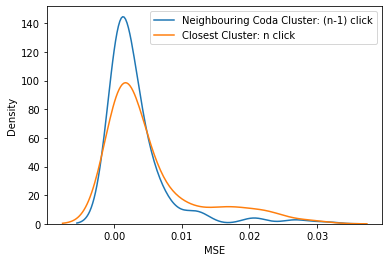

In [11]:
import numpy as np # for random data
import pandas as pd  # for convinience
import matplotlib.pyplot as plt  # for graphics
import seaborn as sns  # for nicer graphics


plt.figure()
# plt.hist(nec[:-3], histtype='barstacked',bins=BINS, density=True);
sns.kdeplot(mse_neighbour);
sns.kdeplot(mse_self);
plt.legend(['Neighbouring Coda Cluster: (n-1) click','Closest Cluster: n click'], loc=1)
plt.xlabel('MSE')

In [12]:
a = (mse_self+mse_neighbour).copy()
t_obs = np.mean(mse_self)-np.mean(np.array(mse_neighbour))

means_batches = []
for N in range(10000):
    random.shuffle(a)
    set_x = a[:len(mse_neighbour)]
    set_y = a[len(mse_neighbour):]
    
    means_batches.append(np.mean(np.array(set_y))-np.mean(np.array(set_x)))
    
def compute_quantile(value, data):
    sorted_data = sorted(data)
    length = len(sorted_data)
    
    # Find the position where the value would be inserted
    position = 0
    for i in range(length):
        if sorted_data[i] >= value:
            position = i
            break
        position = length
    
    # Calculate the quantile
    quantile = (position + 1) / length
    
    return quantile

In [13]:
1-compute_quantile(t_obs,means_batches)

0.0020999999999999908

In [14]:
ct = 0
for i in range(len(means_batches)):
    if t_obs>means_batches[i]:
        ct+=1

In [15]:
1-(ct/len(means_batches))

0.0021999999999999797

Compare the difference between the final two ICIs, normalized by the penultimate ICI, to reduce variance arising from rubato. This measurement exhibits a significant difference in distribution in ornamented vs non-ornamented codas

In [16]:
ici_ec_n = []
ici_ec_n_1 =[]

ici_n = []
ici_n_1 =[]


for i in range(len(extra_click)):
    if extra_click[i]==1:
        if my_data[i+1,1+my_data[i+1,1].astype(int)].astype(float)<0.01:
            print(i)

        ici_ec_n.append(my_data[i+1,0+my_data[i+1,1].astype(int)].astype(float))
        ici_ec_n_1.append(my_data[i+1,1+my_data[i+1,1].astype(int)].astype(float))

    elif extra_click[i]==0:
        ici_n.append(my_data[i+1,0+my_data[i+1,1].astype(int)].astype(float))
        ici_n_1.append(my_data[i+1,1+my_data[i+1,1].astype(int)].astype(float))


In [17]:
ec = []
nec = []

for i in range(len(ici_n)):
    if (-ici_n[i]+ici_n_1[i])/ici_n[i]<10:
        nec.append((-ici_n[i]+ici_n_1[i])/ici_n[i])

for i in range(len(ici_ec_n)):
    if (-ici_ec_n[i]+ici_ec_n_1[i])/ici_ec_n[i]<10:
        ec.append((-ici_ec_n[i]+ici_ec_n_1[i])/ici_ec_n[i])

In [18]:
nec.sort()
ec.sort()

Text(0.5, 0, '(last ICI - penultimate ICI) / penultimate ICI')

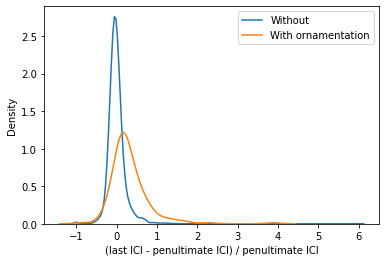

In [19]:
import numpy as np # for random data
import pandas as pd  # for convinience
import matplotlib.pyplot as plt  # for graphics
import seaborn as sns  # for nicer graphics


plt.figure()
sns.kdeplot(nec);
sns.kdeplot(ec);
plt.legend(['Without','With ornamentation'], loc=1)
plt.xlabel('(last ICI - penultimate ICI) / penultimate ICI')

In [20]:
from scipy.stats import ks_2samp
ks_2samp(ec, nec)

KstestResult(statistic=0.5189840925524223, pvalue=1.6653345369377348e-15)

In [21]:
import scipy.stats as stats
import numpy as np

def ks_test_ci(data, cdf, alpha=0.05):
    # Perform the Kolmogorov-Smirnov test
    d_stat, p_value = stats.kstest(data, cdf)
    
    # Compute the critical value
    n = len(cdf)
    crit_value = stats.kstwobign.ppf(1 - alpha / 2) / np.sqrt(205)
    
    # Compute the confidence intervals
    lower_ci = max(0, d_stat - crit_value)
    upper_ci = min(1, d_stat + crit_value)
    
    return d_stat, p_value, lower_ci, upper_ci

# Example usage
data = np.random.normal(0, 1, 100)  # Sample data from a normal distribution
cdf = 'norm'  # Cumulative distribution function to test against

d_stat, p_value, lower, upper = ks_test_ci(ec, nec)

print("Kolmogorov-Smirnov Test Results:")
print(f"Test Statistic: {d_stat}")
print(f"P-value: {p_value}")
print("Confidence Intervals:")
print(f"Lower: {lower}")
print(f"Upper: {upper}")

Kolmogorov-Smirnov Test Results:
Test Statistic: 0.5189840925524223
P-value: 1.6653345369377348e-15
Confidence Intervals:
Lower: 0.4156019612292776
Upper: 0.622366223875567


a significantly greater proportion of ornamented codas appear at the beginning of call sequences than unornamented codas. 
A significantly greater fraction of ornamented codas also appear at the end of call sequences compared to unornamented codas

In [22]:
blocks = []

prev_conv = file_names[0][:6]
dialogue = []
prev_t = TsTo[0]

ids_all = list(range(0,my_data.shape[0]-1))


while len(ids_all)!=0:
    i = ids_all[0] 
    ids_all.remove(i)
    while i!=-1:
        curr_conv = file_names[i][:6]
        curr_t = TsTo[i]
        if curr_conv==prev_conv and curr_t-prev_t<8:
            dialogue.append(i)
        else:
            blocks.append(dialogue)
            dialogue = []
            dialogue.append(i)
        prev_conv = curr_conv
        prev_t = curr_t

        i = getNextCoda(i)
        if i!=-1:
            ids_all.remove(i)
    blocks.append(dialogue)
    dialogue = []

In [22]:
location_ornament = []

for i in range(len(blocks)):
    conv = blocks[i]
    if len(conv)>1:
        for j in range(len(conv)):
            if extra_click[conv[j]]==1:
                id_ec = conv[j]
                id_st = conv[0]
                id_en = conv[-1]
                if (TsTo[id_en]-TsTo[id_st])==0:
                    location_ornament.append(0)
                    print("here")
                else:
                    location_ornament.append((TsTo[id_ec]-TsTo[id_st])/ (TsTo[id_en]-TsTo[id_st]))

In [23]:
baseline = []

for i in range(len(blocks)):
    conv = blocks[i]
    if len(conv)>1:
        for j in range(len(conv)):
            if extra_click[conv[j]]!=1:
                id_ec = conv[j]
                id_st = conv[0]
                id_en = conv[-1]
                if (TsTo[id_en]-TsTo[id_st])==0:
                    a =1
    #                 where.append(0)
    #                 print("here")
                else:
                    baseline.append((TsTo[id_ec]-TsTo[id_st])/ (TsTo[id_en]-TsTo[id_st]))

Text(0, 0.5, 'Counts')

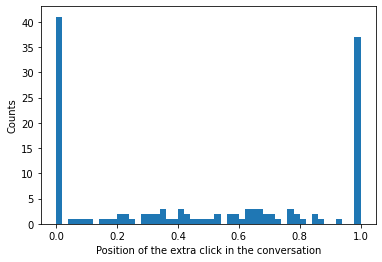

In [24]:
import numpy as np # for random data
import pandas as pd  # for convinience
import matplotlib.pyplot as plt  # for graphics
import seaborn as sns  # for nicer graphics


plt.figure()
plt.hist(location_ornament, histtype='barstacked',bins=50);

plt.xlabel('Position of the extra click in the conversation')
plt.ylabel('Counts')

In [25]:
# Fisher's exact test

In [26]:
# Start of conversation

ornament_st = 0
ornament_remaining = 0

for i in range(len(location_ornament)):
    if location_ornament[i]==0:
        ornament_st+=1
    else:
        ornament_remaining+=1

coda_st = 0
coda_rem = 0
for i in range(len(baseline)):
    if baseline[i]==0:
        coda_st+=1
    else:
        coda_rem+=1
        
print(ornament_st,coda_st,ornament_remaining,coda_rem)
fisher_exact([[ornament_st,coda_st],[ornament_remaining,coda_rem]])

41 594 100 2893


(1.9968518518518519e+00, 0.0006029808644194587)

In [27]:
# end of conversation

ornament_en = 0
ornament_remaining = 0

for i in range(len(location_ornament)):
    if location_ornament[i]==1:
        ornament_en+=1
    else:
        ornament_remaining+=1

coda_en = 0
coda_rem = 0
for i in range(len(baseline)):
    if baseline[i]==1:
        coda_en+=1
    else:
        coda_rem+=1
print(ornament_en,coda_en,ornament_remaining,coda_rem)
       
fisher_exact([[ornament_en,coda_en],[ornament_remaining,coda_rem]])

37 598 104 2889


(1.7187580396192437e+00, 0.008848782517951641)

Compared to unornamented codas, ornamented codas from the leading whale are disproportionately succeeded by a change in chorusing behavior from the following whale

In [28]:
blocks = []

prev_conv = file_names[0][:6]
dialogue = []
prev_t = TsTo[0]
for i in range(0,my_data.shape[0]-1):
    curr_conv = file_names[i][:6]
    curr_t = TsTo[i]
    if curr_conv==prev_conv and curr_t-prev_t<12:
        dialogue.append(i)
    else:
        blocks.append(dialogue)
        dialogue = []
        dialogue.append(i)
    prev_conv = curr_conv
    prev_t = curr_t
blocks.append(dialogue)

In [29]:
block_interrupt = []

for i in range(len(blocks)):
    conv = blocks[i]
    new_conv = []
    j=0
    while j<(len(conv)):
        if j==len(conv)-1:
            new_conv.append(0)
            j+=1
        else:
            id_curr = conv[j]
            id_next = conv[j+1]
            if TsTo[id_next]-TsTo[id_curr]<2:
                new_conv.append(1)
                new_conv.append(1)
                j+=2
            else:
                new_conv.append(0)
                j+=1
    block_interrupt.append(new_conv)

In [30]:
# For extra click clicks
ct = 0
tot = 0
click = []
ct_ec = 0
al=0
for i in range(len(block_interrupt)):
    conv = block_interrupt[i]
    ids = blocks[i]
    for j in range(len(conv)):
        if extra_click[ids[j]]==1:
            ct_ec+=1
            
            curr_conv = conv[j]
            neighbourhood = conv[max(0,j):min(len(conv)-1,j+5)]
            
            id_ec = ids[j]
            id_st = ids[0]
            id_en = ids[-1]
            frac = (TsTo[id_ec]-TsTo[id_st])/ (TsTo[id_en]-TsTo[id_st])
            
            if (TsTo[id_en]-TsTo[id_st])!=0:
                if 1-curr_conv in neighbourhood or j==len(conv)-1:
                    ct+=1
                    tot+=1
                    click.append(1)
                else:
                    tot+=1
                    click.append(0)


/tmp/ipykernel_212855/207169217.py:20: RuntimeWarning: invalid value encountered in double_scalars
  frac = (TsTo[id_ec]-TsTo[id_st])/ (TsTo[id_en]-TsTo[id_st])


In [31]:
ec_p,ec_n = ct, tot-ct
ct, tot-ct

(93, 57)

In [32]:
# For remaining codas
ct = 0
tot = 0
no_click = []
for i in range(len(block_interrupt)):
    conv = block_interrupt[i]
    ids = blocks[i]
    for j in range(len(conv)):
        l = ids[max(0,j-4):min(len(conv)-1,j+4)]
        ec = [extra_click[t] for t in l]
        if len(ec)>0 and extra_click[ids[j]]!=1 and max(ec)==0:
            curr_conv = conv[j]
            neighbourhood = conv[max(0,j):min(len(conv)-1,j+5)]
            
            id_ec = ids[j]
            id_st = ids[0]
            id_en = ids[-1]
            frac = (TsTo[id_ec]-TsTo[id_st])/ (TsTo[id_en]-TsTo[id_st])
            
            if (TsTo[id_en]-TsTo[id_st])!=0:
                if 1-curr_conv in neighbourhood or j==len(conv)-1:
                    ct+=1
                    tot+=1
                    no_click.append(1)
                else:
                    tot+=1
                    no_click.append(0)

In [33]:
coda_p,coda_n = ct, tot-ct
ct, tot-ct

(1524, 1461)

In [34]:
from scipy.stats import fisher_exact

res = fisher_exact([[ec_p,coda_p],[ec_n,coda_n]])
res

(1.564131786158309e+00, 0.009367637518872752)